# Aerosol timeseries (ESGF)

#### Requirements:
- Python (Anaconda recommended)
    - IDE / Text editor that can handle Jupyter Notebooks
    - Packages:
    - xarray
    - esgf-pyclient
    - matplotlib
    - pandas
    - numpy
    - metpy
    - tqdm (optional)
- System:
    - Tested on Windows but should work on Linux, too

#### Other:
- If there are many datasets, the program can be quite slow. I've added a few progress bars to the longest tasks
- This program has been tested with ccn, conccn, cdnc, cldncl, conccmcn, concnmcn but should work with other variables, too (with slight modifications) \
but changes at ESGF's end can break the program in the future.
Hint: if data isn't found, check table_id. With the tested aerosols this is usually either Emon or AERmon


In [77]:
from pyesgf.search import SearchConnection
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib
import pandas as pd
import numpy as np
import re
import warnings
import os
from tqdm.notebook import tqdm
from metpy.units import units
from metpy.calc import sigma_to_pressure
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)
#alternative with a bit different default settings
#conn = SearchConnection('https://esgf-data.dkrz.de/esg-search', distrib=True)

#useful documention about pyesgf and its usage -> https://esgf-pyclient.readthedocs.io/_/downloads/en/latest/pdf/

In [78]:
#disabling warnings
warnings.simplefilter("ignore")
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "0"

In [79]:
#date range we're interested in
min_date = dt(1980,1,1)
max_date = dt(2022,12,31)

#position (lat,lon,lev)
# in this example we're usinng the Pallas station (Muonio Sammaltunturi) in Lapland
p_lat = 67.97 #degrees north
p_lon = 24.12 #degrees east
p_height = 555.0 #meters above sea

#constraints (variable, experiment, table)
#other contrains can also be added (e.g. source_id, “from_timestamp, “to_timestamp, member_id)
var = "conccn"
exp = "historical, ssp370"
tbl = "Emon"

#search for matches
ctx = conn.new_context(
table_id = tbl,
variable_id = var,
experiment_id = exp,
)
#check if matches found
if ctx.hit_count == 0:
    print("No datasets found")
    raise SystemExit()
else:
    #if yes, print number of matches and get matches
    print(ctx.hit_count)
    result = ctx.search()

249


In [89]:
#model names ("source_id", "experiment_id")
model_list = []
#collection of files for each model
ds = {}
#helper dictionary used to see if a failure has occured earlier
rep = {}
#number of allowed failures per model
#recommeded number is 1, because larger numbers tend to slow the program
failures = 1
#current index
idx = 0

#progress bar
with tqdm(total=len(result), colour="green") as pbar:
    #loop through result items
    for id in range(len(result)):
        #catch identifying information
        match = re.findall(r"[|_\w\d-]+", result[idx].dataset_id)
        idx += 1
        #number of tries 0 -> no failures
        rep.setdefault((match[3],match[4]), 0)
        #update progress bar
        pbar.update(1)
        #proceed if model not already added and item includes files and max number of tries hasn't been surpassed 
        if not (match[3],match[4]) in model_list and len(result[id].file_context().search()) != 0 and rep[(match[3],match[4])] <= failures:
            #add number of tries
            rep[(match[3],match[4])] += 1
            #get associated files
            files = result[id].file_context().search()
            try:
                for file in files:
                    #finds the date part of the filename
                    x = re.search(r"(1[89]|2[01])\d{4}-\d{6}",file.opendap_url)
                    #split start and end
                    x = x.group().split("-")
                    #start time
                    x1 = dt.strptime(x[0], "%Y%m")
                    #end time
                    x2 = dt.strptime(x[1], "%Y%m")
                    #in the example the period is 1.1.1980-2022-12-31
                    if x1 <= min_date <= x2 or (x1 >= min_date and x2 <= max_date) or x1 <= max_date <= x2:
                        #open dataset
                        dset = xr.open_dataset(file.opendap_url)
                        #datasets together in a dictionary
                        ds.setdefault((match[3],match[4]), []).append(dset)
                        print(f"Successfully added a file of {match[3]} ({match[4]})")
            except:
                #this happens e.g. when a file doesn't contain dataset
                print("Error occured, tring again")
                #in case some files worked, they need to be removed for another try
                try:
                    del ds[(match[3],match[4])]
                except:
                    pass
                continue
            #if everything goes well, model can be crossed out and will be skipped in the future
            model_list.append((match[3],match[4]))
source = []
experiment = []
for i in model_list:
    source.append(i[0])
    experiment.append(i[1])
for i in range(len(source)):
    if not source.count(source[i]) == 2: 
        del ds[(source[i],experiment[i])]

  0%|          | 0/249 [00:00<?, ?it/s]

Successfully added a file of UKESM1-0-LL (historical)
Successfully added a file of UKESM1-0-LL (historical)
Successfully added a file of CESM2-FV2 (historical)
Successfully added a file of CESM2-FV2 (historical)
Successfully added a file of CESM2-WACCM-FV2 (historical)
Successfully added a file of CESM2-WACCM-FV2 (historical)
Successfully added a file of UKESM1-0-LL (ssp370)
Successfully added a file of MIROC-ES2L (historical)
Successfully added a file of CESM2-WACCM (ssp370)
Successfully added a file of MIROC-ES2L (ssp370)
Successfully added a file of CESM2 (historical)
Successfully added a file of CESM2 (historical)
Successfully added a file of CESM2-WACCM (historical)
Successfully added a file of MRI-ESM2-0 (historical)
Successfully added a file of MRI-ESM2-0 (historical)
Successfully added a file of MRI-ESM2-0 (historical)
Successfully added a file of MRI-ESM2-0 (historical)
Successfully added a file of MRI-ESM2-0 (ssp370)
Successfully added a file of CESM2 (ssp370)
Successfully ad

In [103]:
#length of proggres bar
length = sum([len(ds[x]) for x in ds])

In [91]:
#transform the vertical coordinate into height
def height(pressure):
    #if units are in meters, do nothing
    if pressure.lev.units == "m":
        return pressure
    #if we have sigma pressure, turn it into regular pressure
    elif pressure.lev.units == "1" or pressure.lev.units == "1.0":
        #from 1000 hPa to 0 hPa (approximation)
        levels = sigma_to_pressure(pressure.lev.values, 1000*units.hPa, 0*units.hPa)
        levels = levels.magnitude
    elif pressure.lev.units == "hPa":
        levels = pressure.lev.values
    #if Pa, convert to hPa
    elif pressure.lev.units == "Pa":
        levels = pressure.lev.values/1000
    #convert pressure into height
    height = [(145366.45*(1-(abs(P/1013.25))**0.190284))*0.3048 for P in levels]
    #assign new height coordinates
    pressure = pressure.assign_coords(lev=height)
    return pressure

#narrowing down the coordinates and time

#"refined" data
ref_set = {}
#temporary variable for concatenation
con = "0"
#progress bar
with tqdm(total=length, colour="green") as pbar:
    #model
    for dset in ds:
        #dataset
        for elem in ds[dset]:
            #if data has a vertical coordinate
            if "lev" in elem.dims or "presnivs" in elem.dims:
                #make sure that it's called "lev"
                if "presnivs" in elem.dims:
                    elem = elem.rename({"presnivs": "lev"})
                #convert to height
                elem = height(elem)
            #data-array of the variable
            elem_var = elem[var]
            #renaming the dims since they're not always consistent. Some datasets have 4 and some 3 dimensions
            if len(elem_var.dims) == 4:
                elem_var = elem_var.rename({elem_var.dims[0] : "time", elem_var.dims[1] : "lev", elem_var.dims[2] : "lat", elem_var.dims[3] : "lon"})     
            else:
                elem_var = elem_var.rename({elem_var.dims[0] : "time", elem_var.dims[1] : "lat", elem_var.dims[2] : "lon"})
            #choosing the nearest grid cell to wanted location
            lat = min(elem_var.lat, key=lambda x:abs(x-p_lat))
            lon = min(elem_var.lon, key=lambda x:abs(x-p_lon))
            
            #normalizing date formats 
            elem_var["time"] = elem_var["time"].astype("datetime64[ns]")

            #narrowing down spatial data
            if "lev" in elem_var.dims:
                #choose height level
                lev = min(elem_var.lev, key=lambda x: abs(x-p_height))
                #select coordinates
                temp = elem_var.sel(lat=lat, lon=lon, lev=lev)
            else:
                #select coordinates 
                temp = elem_var.sel(lat=lat, lon=lon)
            
            #concatenate data if more than one dataset per model
            if len(con) != 1 and len(ds[dset]) != 1:
                con = xr.concat(objs=(con, temp),dim="time", join="override")
            else:
                #first/only dataset
                con = temp
            #update progress bar
            pbar.update(1)
        #narrowing down temporal data (dataset might start at 1950 while we're interested in 1955-)
        con = con.sel(time=slice(min_date, max_date))
        #link model and data
        ref_set[dset] = con
        con = "0"

  0%|          | 0/15 [00:00<?, ?it/s]

In [92]:
#connecting experiments
con_set = {}
#sort dict so that models are next to each other
sorted_dict = {k: ref_set[k] for k in sorted(ref_set)}
temp = ""
for i in sorted_dict:
    #first
    if len(temp) == 0:
        temp = sorted_dict[i]
    #second
    else:
        #convert to cm^3
        if np.mean(temp.values) < 1:
            #this seems to be a bug but some data requires the opposite operation
            temp = temp*1e6
        else:
            #m^3 -> cm^3
            temp = temp*1e-6
        #same for other part
        if np.mean(sorted_dict[i].values) < 1:
            sorted_dict[i] = sorted_dict[i]*1e6
        else:
            sorted_dict[i] = sorted_dict[i]*1e-6
        #combine data
        con_set[i[0]] = xr.concat(objs=(temp, sorted_dict[i]),dim="time", join="override")
        temp = ""

Text(0, 0.5, 'Aerosol Number Concentration \n [cm^3]')

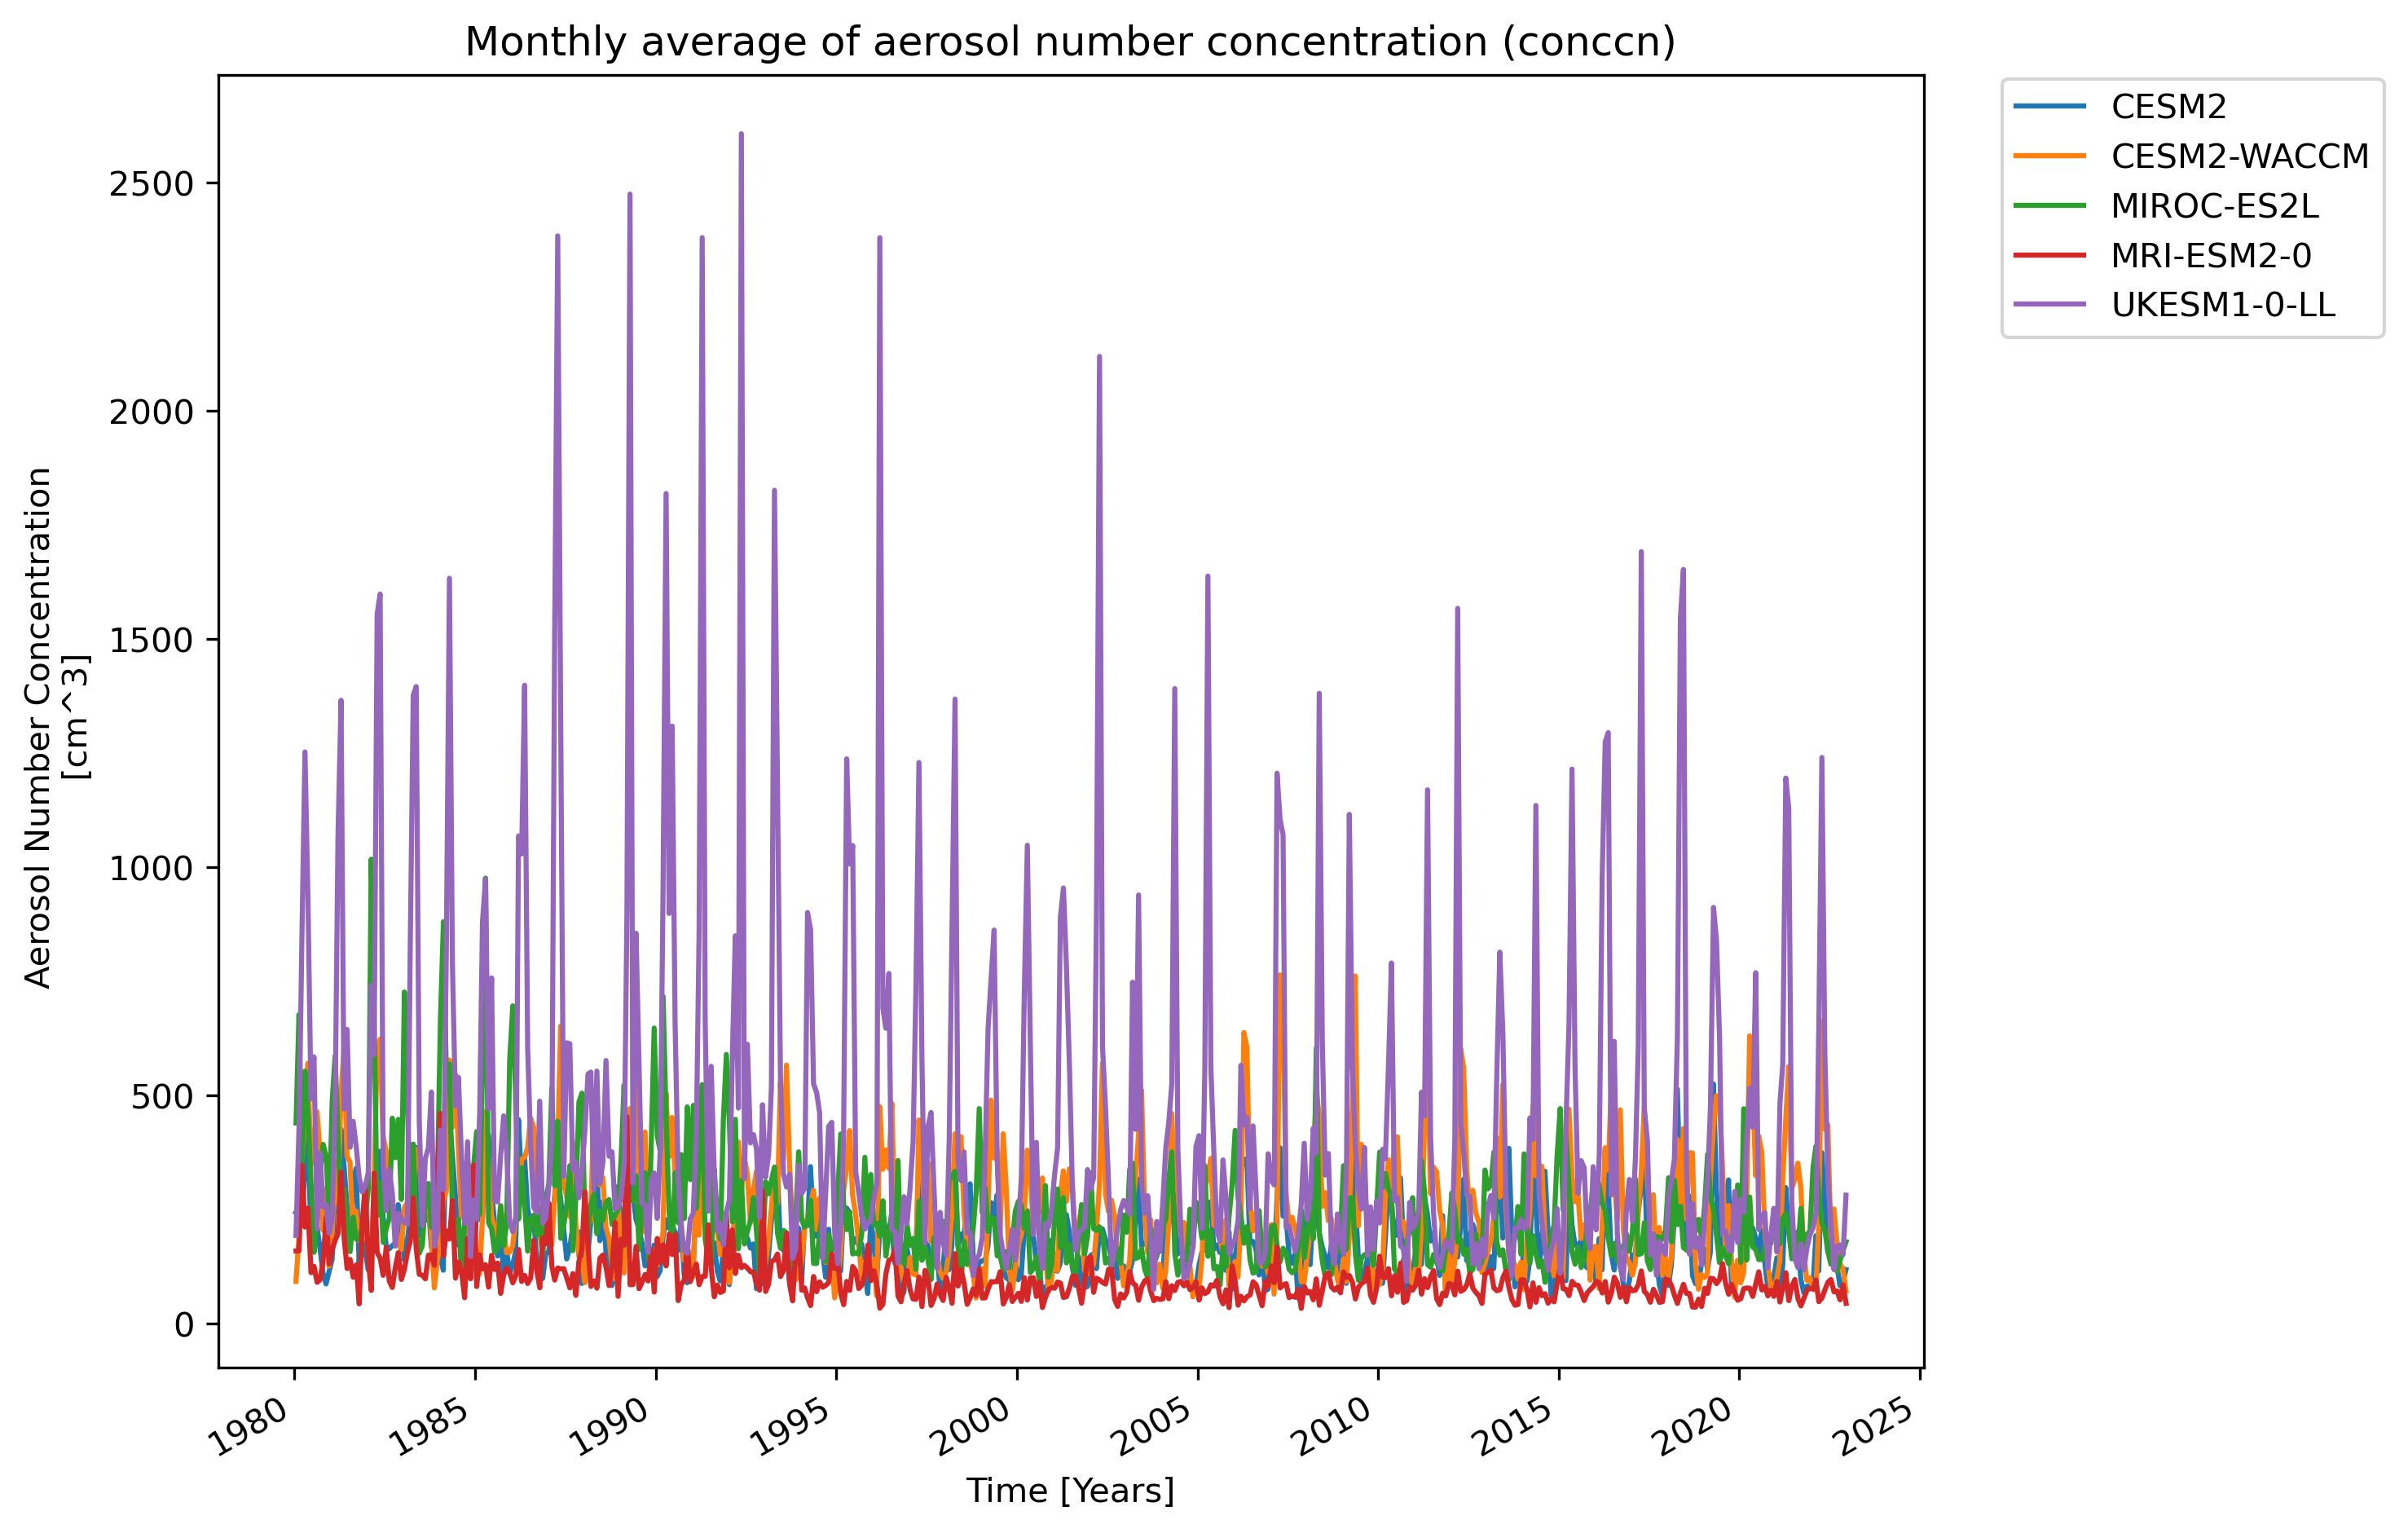

In [93]:
#monthly plot

#set figure size
fig = plt.figure(figsize=(9,7))
#set dots-per-inch
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
for model, data in con_set.items():
    #plot each model with names
    data.plot(label=model)
plt.legend()

#move legend
#these parameters (x,y) might have to be modified depending on the data
plt.legend(bbox_to_anchor=(1.28,1.01))
#set title
try:
    long_name = ds[list(ds.keys())[0]][0][var].long_name
    name = var
    plt.title(f"Monthly average of {long_name.lower()} ({name})")
except:
    plt.title(f"Monthly average of {name}")
    long_name = var
#axis labels
plt.xlabel("Time [Years]")
plt.ylabel(f"{long_name} \n [cm^3]")
#save picture
#fig.savefig(f"{str(name)}_yearly.pdf", bbox_inches="tight")

In [94]:
#months have different lengths
def weighted_temporal_mean(ds):
  #source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
  """
  weight by days in each month
  """
  # Determine the month length
  month_length = ds.time.dt.days_in_month

  # Calculate the weights
  wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

  # Make sure the weights in each year add up to 1
  np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)


  # Setup our masking for nan values
  cond = ds.isnull()
  ones = xr.where(cond, 0.0, 1.0)

  # Calculate the numerator
  obs_sum = (ds * wgts).resample(time="AS").sum(dim="time")

  # Calculate the denominator
  ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

  # Return the weighted average
  return obs_sum / ones_out

In [95]:
#create trendline
def plot_trend(data):
    #temporary x-axis
    x = np.linspace(0, 100, len(data["time"]))
    #y-axis, fill NaN with 0
    y = data.fillna(value=0)
    #calculate equation for trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    return p(x)

Text(0, 0.5, 'Aerosol Number Concentration \n [cm^3]')

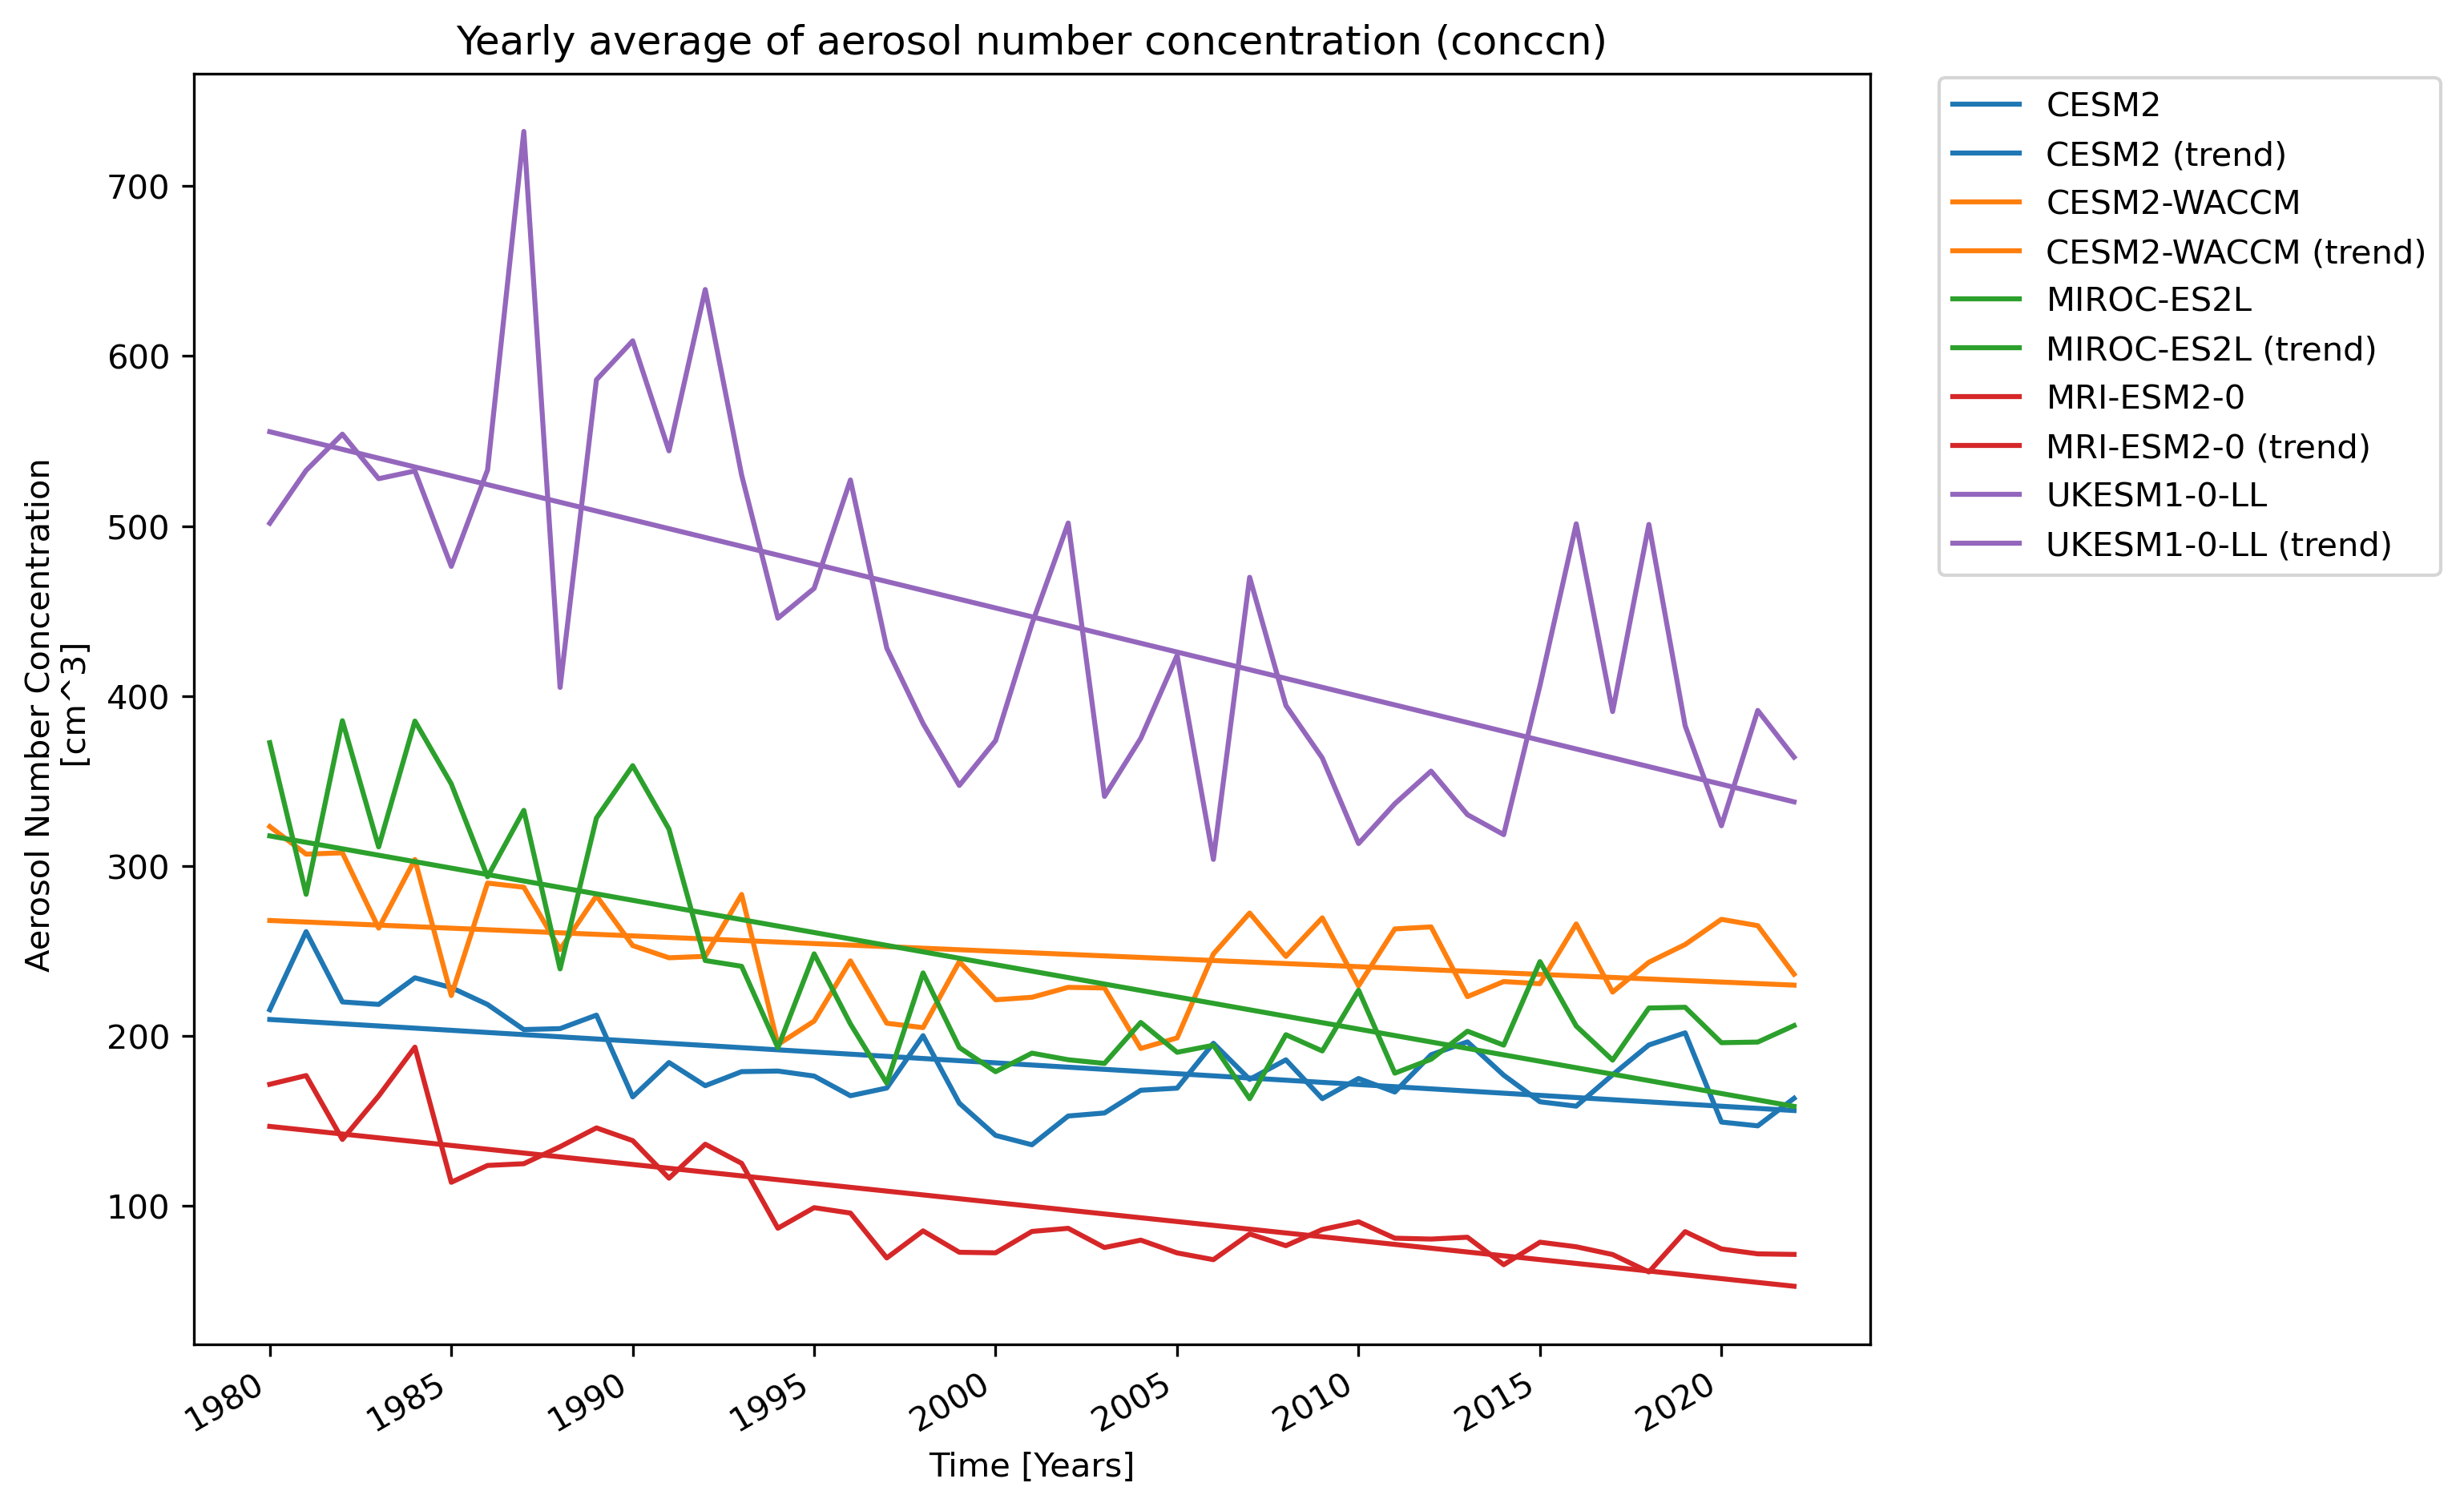

In [96]:
#yearly plot
#set figure size
fig = plt.figure(figsize=(9,7))
#set dots-per-inch
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
for model, data in con_set.items():
    #weigh data by the month length
    data = weighted_temporal_mean(data)
    #same color for data and trend
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    #plot each model
    data.plot(label=model, color=color)
    #plot trendline
    plt.plot(data["time"], plot_trend(data), label=f"{model} (trend)", color=color)
#move legend
#these parameters (x,y) might have to be modified depending on the data
plt.legend(bbox_to_anchor=(1.35,1.01))
#set title
try:
    long_name = ds[list(ds.keys())[0]][0][var].long_name
    name = var
    plt.title(f"Yearly average of {long_name.lower()} ({name})")
except:
    plt.title(f"Yearly average of {name}")
    long_name = var
#axis labels
plt.xlabel("Time [Years]")
plt.ylabel(f"{long_name} \n [cm^3]")
#save picture
#fig.savefig(f"{str(name)}_yearly.pdf", bbox_inches="tight")
